In [1]:
import librosa
import matplotlib.pyplot as plt 
import numpy as np 
import torch
from IPython.display import Audio
from model.layers import TacotronSTFT
from audio_processing import griffin_lim
from text.pinyin_preprocess import get_phoneme_from_pinyin

# 声学模型数据处理示例

这个notebook展示了声学模型涉及到的文本特征和声学特征的预处理过程。

![](assets/data-pipeline.png)

## 1. 文本特征的预处理

AISHELL-3 数据集本身包括了44.1kHz采样率的语音样本看，以及配套的文本信息。文本信息包括两个部分，汉字和拼音。
这里需要注意的是汉字和拼音标注的关系。在 AISHELL-3 的采集过程中，汉字标注是先于录音、作为录音人员的台本的。
而拼音则是在录音结束后由标注员手工标注的。因此会出现拼音标注不是汉字的标准发音的情况。这种情况下我们从发音的角度应该采信拼音标注。

下一个代码块中的`contenet`展示了 AISHELL-3 标注文件中的某一行。

In [2]:
content = 'SSB00050002.wav 尊 zhun1 重 zhong4 科 ke1 学 xue2 规 gui1 律 lv4 的 de5 要 yao1 求 qiu2'
sid = content.split()[0]
hans = content.split()[1::2]
pinyin = content.split()[2::2]
print(sid, hans, pinyin)
display(Audio('assets/SSB00050002.wav'))


SSB00050002.wav ['尊', '重', '科', '学', '规', '律', '的', '要', '求'] ['zhun1', 'zhong4', 'ke1', 'xue2', 'gui1', 'lv4', 'de5', 'yao1', 'qiu2']


In [3]:
! soxi assets/SSB00050002.wav


Input File     : 'assets/SSB00050002.wav'
Channels       : 1
Sample Rate    : 44100
Precision      : 16-bit
Duration       : 00:00:03.54 = 155933 samples = 265.192 CDDA sectors
File Size      : 312k
Bit Rate       : 706k
Sample Encoding: 16-bit Signed Integer PCM



这里 `get_phoneme_from_pinyin` 将拼音标注通过规则与查表的方式首先分割为了“声母”、“韵母”、“声调”、\[“儿化音标志”\]四个部分，然后按照：
“声母” 、“韵母+声调”、\[“er5”\] 的方式作为转换后的文本特征。并在汉字之间插入 `#1` 符号，在文本开始和结尾处插入 `sil` 符号

In [4]:
phoneme, _ = get_phoneme_from_pinyin(pinyin)
print(phoneme)

['sil', 'zh', 'uen1', '#0', 'zh', 'ong4', '#0', 'k', 'e1', '#0', 'x', 've2', '#0', 'g', 'uei1', '#0', 'l', 'v4', '#0', 'd', 'e5', '#0', '^', 'iao1', '#0', 'q', 'iou2', 'sil']


## 2. 声学特征的预处理

wave: (77967,), sr: 22050


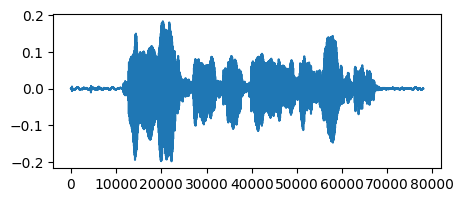

In [5]:
wave, sr = librosa.load('assets/SSB00050002.wav', sr=22050)
print(f'wave: {wave.shape}, sr: {sr}')
_ = plt.figure(figsize=(5,2))
plt.plot(wave)

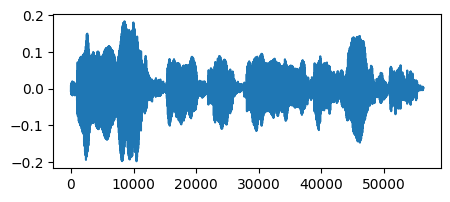

In [6]:
trimmed_wave, _ = librosa.effects.trim(wave, ref=-5)
_ = plt.figure(figsize=(5,2))
plt.plot(trimmed_wave)
display(Audio(trimmed_wave, rate=sr))

In [7]:
stft_layer = TacotronSTFT(
    filter_length=1024, hop_length=256, win_length=1024,
    n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0, mel_fmax=16000/2
)

/Netdata/shiyao/speechhome-ai3/model/stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/Netdata/shiyao/speechhome-ai3/model/layers.py:51: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


/Netdata/shiyao/speechhome-ai3/audio_processing.py:50: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)


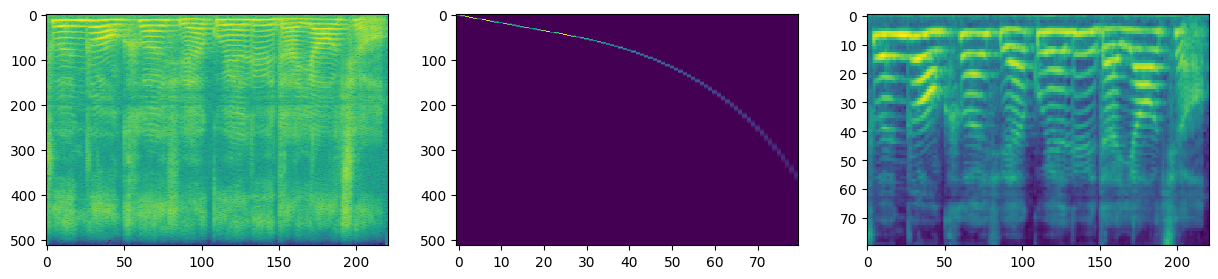

In [8]:
magnitudes, phases = stft_layer.stft_fn.transform(torch.from_numpy(trimmed_wave)[None])
mel_magnitudes = torch.matmul(stft_layer.mel_basis, magnitudes)

fig, (ax_mag, ax_basis, ax_mel) = plt.subplots(1, 3, figsize=(15, 3))
ax_mag.imshow(magnitudes[0].log(), aspect='auto', interpolation='none')
ax_basis.imshow(stft_layer.mel_basis.T, aspect='auto', interpolation='none')
ax_mel.imshow(mel_magnitudes[0].log(), aspect='auto', interpolation='none')

gl_recon_wave = griffin_lim(magnitudes, stft_layer.stft_fn)
display(Audio(gl_recon_wave.squeeze(), rate=sr))

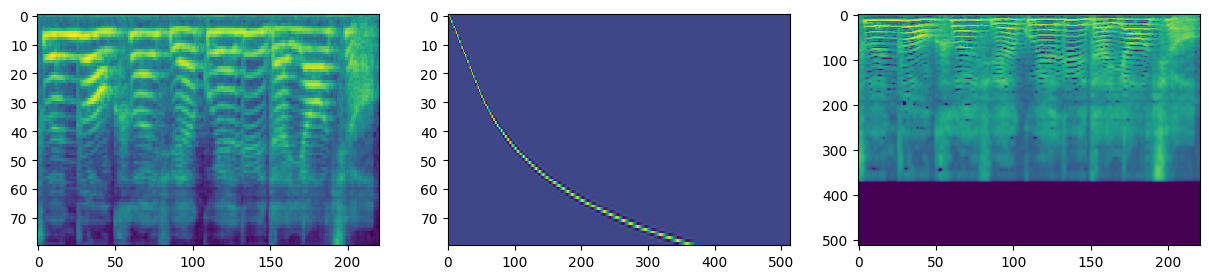

In [9]:
log_mel_magnitudes = torch.log(torch.clamp(mel_magnitudes, min=1e-5))
denormed_mel = torch.exp(log_mel_magnitudes)
recon_mag = torch.matmul(stft_layer.inv_mel_basis, denormed_mel)

fig, (ax_mag, ax_basis, ax_mel) = plt.subplots(1, 3, figsize=(15, 3))
ax_mag.imshow(log_mel_magnitudes[0], aspect='auto', interpolation='none')
ax_basis.imshow(stft_layer.inv_mel_basis.T, aspect='auto', interpolation='none')
ax_mel.imshow(torch.clamp(recon_mag[0], min=1e-5).log(), aspect='auto')

gl_recon_wave = griffin_lim(recon_mag, stft_layer.stft_fn)
display(Audio(gl_recon_wave.squeeze(), rate=sr))

In [10]:
import onnxruntime as ort
voc_session = ort.InferenceSession('exported/hifigan.onnx')
gan_recon_wave, = voc_session.run(None, input_feed={'mel': log_mel_magnitudes.numpy()})
display(Audio(gan_recon_wave.squeeze(), rate=sr))